# Models

## Load data

In [1]:
# load libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# load data

# df_data = pd.read_csv('../data/processed/data.csv')
df_data = pd.read_csv('https://raw.githubusercontent.com/RomanShevtsiv/lending-score-model/master/data/processed/data.csv')
display(df_data.shape)

(10931, 58)

In [3]:
# Do the magic!
df_data['bad'] = df_data['bad'].astype(float)

## Correlation

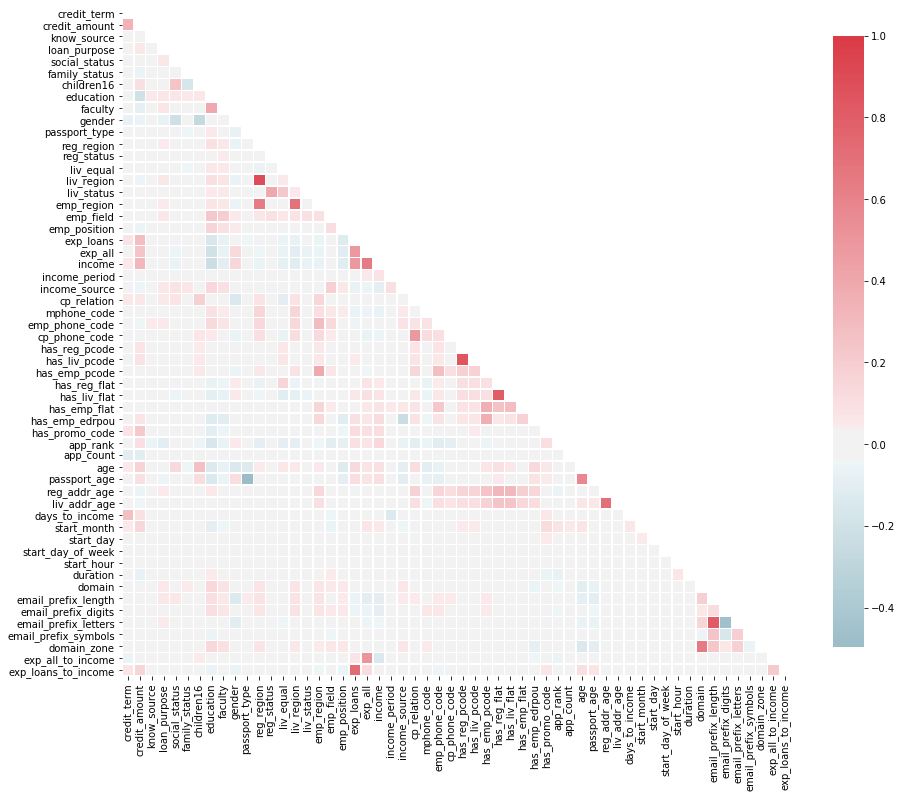

In [4]:
# Compute the correlation matrix
corr = df_data.drop(['bad', 'start_time'], axis='columns').corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(15, 15))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .75})
plt.show()

Some variable pairs have stron correlation and one varibale from a pair can be removed:

- `liv_region`|`reg_region`: remove `liv_region` as `reg_region` is filled and verified better;
- ??? `emp_region`|`reg_region`: remove `emp_region` as `reg_region` is filled and verified better and create boolean variable `emp_region_equal` to account for the cases where the regions are different;
- `has_liv_pcode`|`has_reg_pcode`: remove `has_liv_pcode` as `has_reg_pcode` is filled and verified better;
- `has_liv_flat`|`has_reg_flat`: remove `has_liv_flat` as `has_reg_flat` is filled and verified better;
- ??? `liv_addr_age`|`reg_addr_age`: remove `liv_addr_age` as `reg_addr_age` is filled and verified better;
- `exp_loans`|`exp_loans_to_income`: remove `exp_loans_to_income` as it's derived from `exp_loans`;
- `email_prefix_length`, `email_prefix_letters`: remove `email_prefix_letters` as it contains less info;

!!! `emp_region_equal` was calcultaed in eda-apps.jpnb due to code separation logic

In [5]:
df_data.drop(['liv_region', 'emp_region', 'has_liv_pcode', 'has_liv_flat', 'liv_addr_age',
             'exp_loans_to_income','email_prefix_letters'], 
             axis='columns', inplace=True)

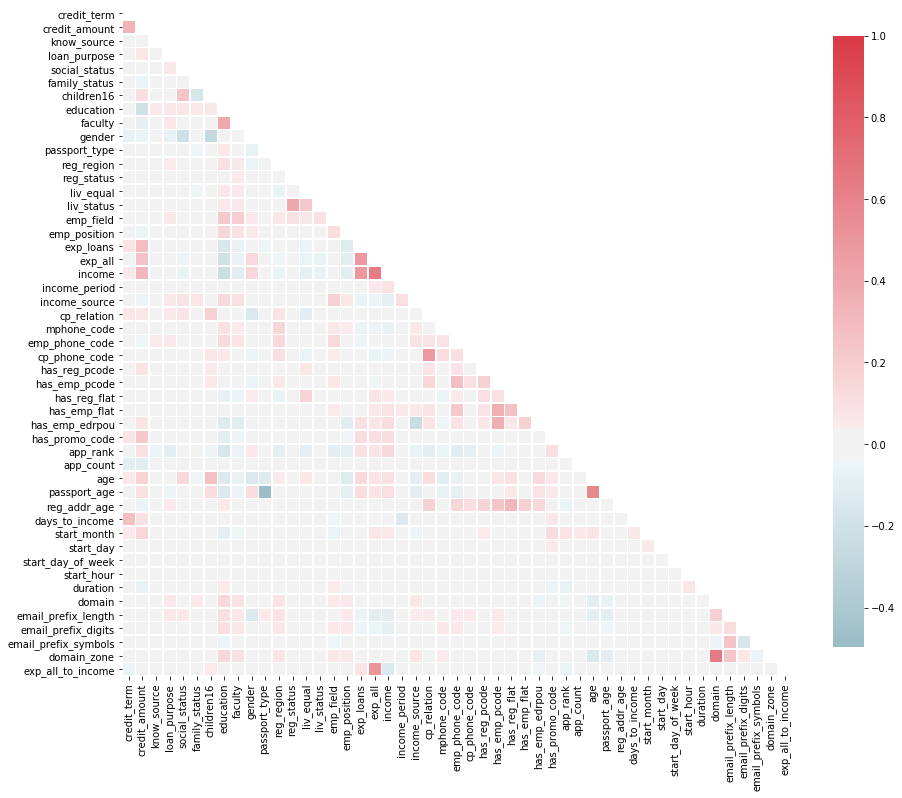

In [6]:
# Compute the correlation matrix
corr = df_data.drop(['bad', 'start_time'], axis='columns').corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(15, 15))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .75})
plt.show()

There are still some possibly high correlations:

- `domain`|`domain_zone`: 0.65;
- `imcome`|`exp_all`: 0.63;
- `passport_age` | `age`: 0.58;
- `exp_all`|`exp_all_to_income`: 0.50;
- `cp_phone_code`|`cp_relation`: 0.48 !!! that's fucking strange !!!
- `imcome`|`exp_loans`: 0.48.

We'll try different setups to address these high correlations.

## Feature importance

In [7]:
from sklearn.model_selection import train_test_split

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    df_data.drop(['bad', 'start_time'], axis='columns'), 
    df_data['bad'], 
    test_size=0.2, 
    stratify=df_data['bad']
)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(8744, 49) (2187, 49) (8744,) (2187,)


In [9]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.patches as mpatches

In [10]:
pca = PCA().fit(X_train)

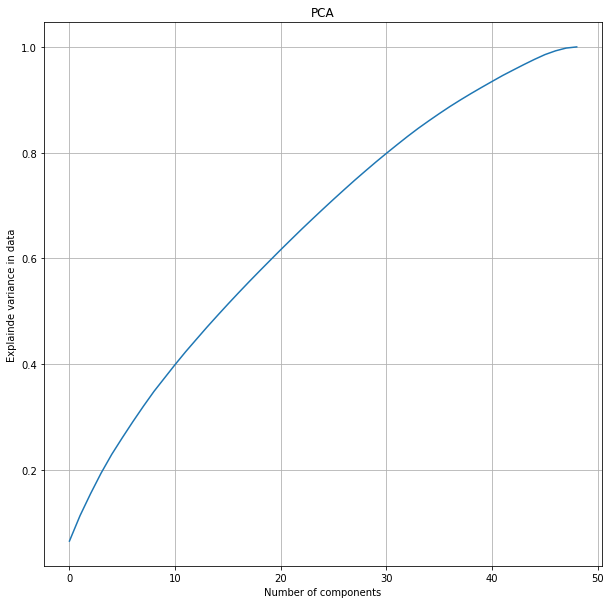

In [11]:
plt.figure(figsize=(10,10))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Explainde variance in data')
plt.title('PCA')
plt.grid()
plt.show()

The figure above shows that we can hardly any significant number of components without loosing tangible amount of information.

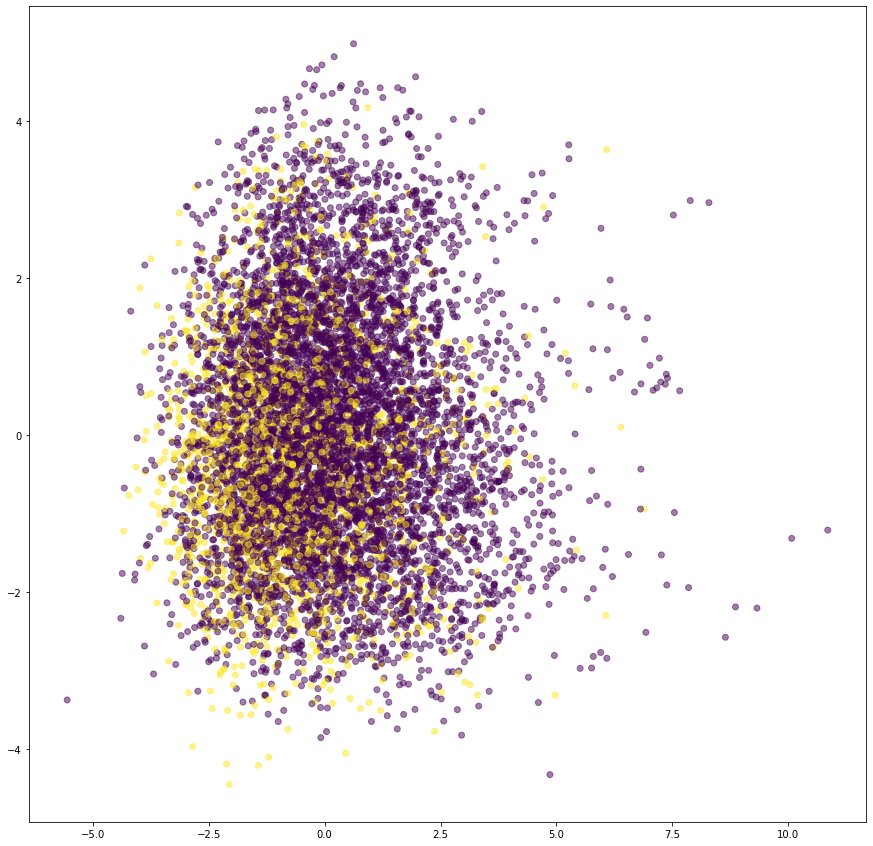

In [12]:
X_pca = pca.transform(X_train)

plt.figure(figsize=(15,15))
ax = plt.scatter(X_pca[:,0], X_pca[:,1], alpha=0.5, c=y_train)
# ax.axes.add_patch(mpatches.Circle(xy=(14,-80), radius=12, color='r', fill=False, linewidth=3))
# ax.axes.add_patch(mpatches.Ellipse(xy=(-10,67), width=50, height=30, color='r', fill=False, linewidth=3))
# ax.axes.add_patch(mpatches.Circle(xy=(37,47), radius=15, color='r', fill=False, linewidth=3))
# ax.axes.add_patch(mpatches.Ellipse(xy=(-16,-39), width=30, height=20, color='r', fill=False, linewidth=3))
plt.show()

PCA with 2 first componets doesn't split the data well it shows some tendenncies only: more yellow points to the bottom-left.

In [13]:
X_embedded = TSNE(n_components=2, n_jobs=-1).fit_transform(X_train)

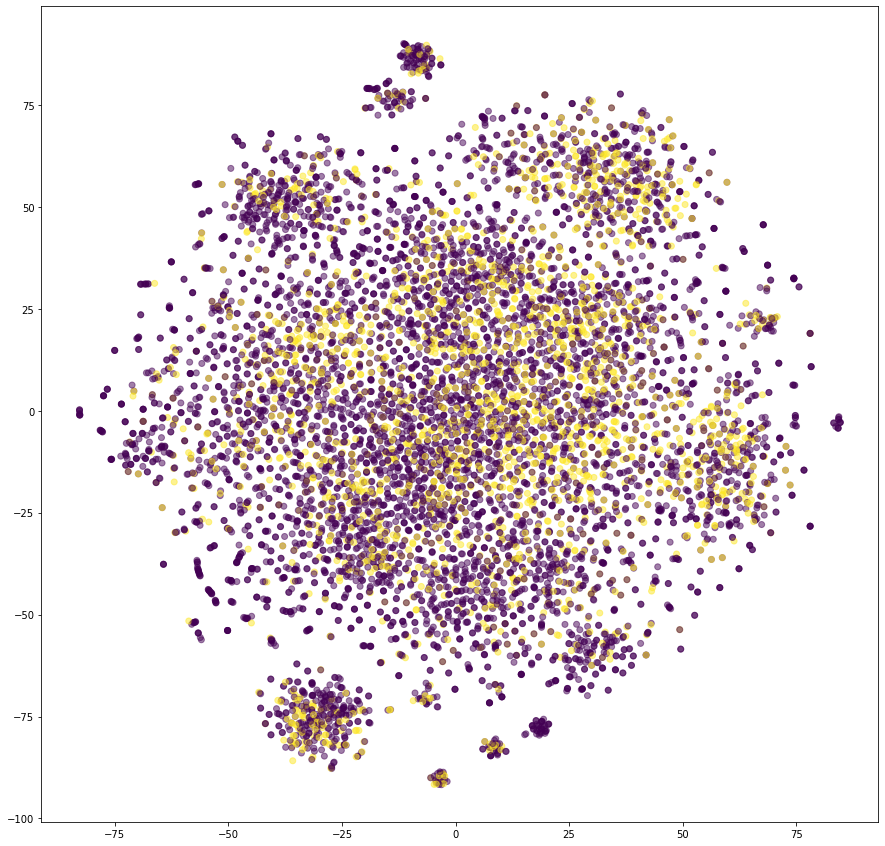

In [14]:
plt.figure(figsize=(15,15))
ax = plt.scatter(X_embedded[:,0], X_embedded[:,1], alpha=0.5, c=y_train)
# ax.axes.add_patch(mpatches.Circle(xy=(14,-80), radius=12, color='r', fill=False, linewidth=3))
# ax.axes.add_patch(mpatches.Ellipse(xy=(-10,67), width=50, height=30, color='r', fill=False, linewidth=3))
# ax.axes.add_patch(mpatches.Circle(xy=(37,47), radius=15, color='r', fill=False, linewidth=3))
# ax.axes.add_patch(mpatches.Ellipse(xy=(-16,-39), width=30, height=20, color='r', fill=False, linewidth=3))
plt.show()

t-SNE failed to identify any serious stuff in data, just some possible minor clusters.

## Modeling

In [15]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix

We'll try the following models:

- `Logistic Regression`
- `SVM`
- `Random Forest`
- `AdaBoost`
- `XGBoost`

We'll use hyperparameter optimization and cross fold validation with 5 folds.

We'l choose **roc_auc** as scoring criteria.

In [16]:
models = pd.DataFrame([], columns=['model', 'parameters', 'score'])

### Logistic Regression

In [17]:
from sklearn.linear_model import LogisticRegression

In [18]:
# Parameters to optimize
params = {
    'penalty': ['l1','l2'],
    'C': [0.01, 0.1, 1, 10, 100],
    'class_weight': [{1.: 3, 0.: 1}]
}

gs_lr = GridSearchCV(
    estimator=LogisticRegression(),
    param_grid=params,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=2
).fit(X_train, y_train)

print('AUC:', gs_lr.best_score_)
print('Optimal parameters:')
print(gs_lr.best_params_)

# save results
models = models.append({
    'model': 'Logistic Regression',
    'parameters': gs_lr.best_params_,
    'score': gs_lr.best_score_
}, ignore_index=True)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  11 out of  50 | elapsed:    1.4s remaining:    5.0s
[Parallel(n_jobs=-1)]: Done  37 out of  50 | elapsed:    1.6s remaining:    0.5s


AUC: 0.7062763662027416
Optimal parameters:
{'C': 0.01, 'class_weight': {1.0: 3, 0.0: 1}, 'penalty': 'l2'}


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.6s finished


### SVM

In [19]:
from sklearn.svm import SVC

In [20]:
# Parameters to optimize
params = [
    {'kernel': ['linear'],
     'C': [0.01, 0.1, 1, 10],
     'class_weight': [{1.: 3, 0.: 1}]
    },
    {'kernel': ['sigmoid'],
     'C': [0.01, 0.1, 1, 10],
     'gamma': [0.001, 0.01, 0.1],
     'class_weight': [{1.: 3, 0.: 1}]
    },
    {'kernel': ['poly'],
     'C': [0.01, 0.1, 1, 10],
     'gamma': [0.001, 0.01, 0.1],
     'degree': [2,3],
     'class_weight': [{1.: 3, 0.: 1}]
    },
    {'kernel': ['rbf'],
     'C': [0.01, 0.1, 1, 10],
     'gamma': [0.001, 0.01, 0.1],
     'class_weight': [{1.: 3, 0.: 1}]
    }
]

gs_svm = GridSearchCV(
    estimator=SVC(),
    param_grid=params,
    cv=3,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=2
).fit(X_train, y_train)

print('AUC:', gs_svm.best_score_)
print('Optimal parameters:')
print(gs_svm.best_params_)

# save results
models = models.append({
    'model': 'svm',
    'parameters': gs_svm.best_params_,
    'score': gs_svm.best_score_
}, ignore_index=True)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.


Fitting 3 folds for each of 52 candidates, totalling 156 fits


[Parallel(n_jobs=-1)]: Done  92 out of 156 | elapsed:   17.1s remaining:   11.9s
[Parallel(n_jobs=-1)]: Done 156 out of 156 | elapsed:  2.8min finished


AUC: 0.7053173884154784
Optimal parameters:
{'C': 1, 'class_weight': {1.0: 3, 0.0: 1}, 'gamma': 0.001, 'kernel': 'sigmoid'}


### Random Forest

In [21]:
from sklearn.ensemble import RandomForestClassifier

In [22]:
# Parameters to optimize
params = {
    'criterion': ['gini','entropy'],
    'n_estimators': [10, 20, 30, 40, 50],
    'max_features': [5, 7, 10],
    'min_samples_leaf': [10, 20, 50, 100],
    'class_weight': [{1.: 3, 0.: 1}]
}

gs_rf = GridSearchCV(
    estimator=RandomForestClassifier(),
    param_grid=params,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=2
).fit(X_train, y_train)

print('AUC:', gs_rf.best_score_)
print('Optimal parameters:')
print(gs_rf.best_params_)

# save results
models = models.append({
    'model': 'Random Forest',
    'parameters': gs_rf.best_params_,
    'score': gs_rf.best_score_
}, ignore_index=True)

Fitting 5 folds for each of 120 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 298 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    4.8s finished


AUC: 0.6922671274619281
Optimal parameters:
{'class_weight': {1.0: 3, 0.0: 1}, 'criterion': 'entropy', 'max_features': 5, 'min_samples_leaf': 10, 'n_estimators': 50}


### AdaBoost

In [23]:
from sklearn.ensemble import AdaBoostClassifier

In [24]:
# Parameters to optimize
params = {
    'n_estimators': [50, 100],
    'learning_rate' : [0.01, 0.05, 0.1, 0.3, 1]
}

gs_ab = GridSearchCV(
    estimator=AdaBoostClassifier(),
    param_grid=params,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=2
).fit(X_train, y_train)

print('AUC:', gs_ab.best_score_)
print('Optimal parameters:')
print(gs_ab.best_params_)

# save results
models = models.append({
    'model': 'AdaBoost',
    'parameters': gs_ab.best_params_,
    'score': gs_ab.best_score_
}, ignore_index=True)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  11 out of  50 | elapsed:    0.6s remaining:    2.3s
[Parallel(n_jobs=-1)]: Done  37 out of  50 | elapsed:    1.4s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.6s finished


AUC: 0.6922256977984212
Optimal parameters:
{'learning_rate': 0.3, 'n_estimators': 100}


### XGBoost

In [25]:
import xgboost as xgb

In [26]:
# Parameters to optimize
params = {
    'min_child_weight': [1, 5, 10],
    'gamma': [0.5, 1, 1.5, 2, 5],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'max_depth': [3, 4, 5],
    'scale_pos_weight': [3]
}

gs_xgb = GridSearchCV(
    estimator=xgb.XGBClassifier(),
    param_grid=params,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=2
).fit(X_train, y_train)

print('AUC:', gs_xgb.best_score_)
print('Optimal parameters:')
print(gs_xgb.best_params_)

# save results
models = models.append({
    'model': 'XGBoost',
    'parameters': gs_xgb.best_params_,
    'score': gs_xgb.best_score_
}, ignore_index=True)

Fitting 5 folds for each of 405 candidates, totalling 2025 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 221 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done 869 tasks      | elapsed:   17.9s
[Parallel(n_jobs=-1)]: Done 1314 tasks      | elapsed:   28.0s
[Parallel(n_jobs=-1)]: Done 1841 tasks      | elapsed:   41.4s
[Parallel(n_jobs=-1)]: Done 2025 out of 2025 | elapsed:   46.5s finished


AUC: 0.6847416751191917
Optimal parameters:
{'colsample_bytree': 1.0, 'gamma': 5, 'max_depth': 3, 'min_child_weight': 10, 'scale_pos_weight': 3, 'subsample': 1.0}


In [27]:
models.sort_values('score', ascending=False)

,model,parameters,score
0,Logistic Regression,"{'C': 0.01, 'class_weight': {1.0: 3, 0.0: 1}, ...",0.706276
1,svm,"{'C': 1, 'class_weight': {1.0: 3, 0.0: 1}, 'ga...",0.705317
2,Random Forest,"{'class_weight': {1.0: 3, 0.0: 1}, 'criterion'...",0.692267
3,AdaBoost,"{'learning_rate': 0.3, 'n_estimators': 100}",0.692226
4,XGBoost,"{'colsample_bytree': 1.0, 'gamma': 5, 'max_dep...",0.684742


All models performs nearly the same. From the simlicity point of view and speed it's better to choose Logistic Regression.

In [28]:
y_pred = gs_lr.predict(X_test)

print('Calssification report:')
print(classification_report(y_test, y_pred))
print('Confusion matrix:')
print(confusion_matrix(y_test, y_pred))

print('\nClass prediction')
print('AUC:', roc_auc_score(y_test, y_pred))
print('Gini:', 2*roc_auc_score(y_test, y_pred) - 1)

print('\nProbability prediction')
y_pred_proba = gs_lr.predict_proba(X_test)
print('AUC:', roc_auc_score(y_test, y_pred_proba[:,1]))
print('Gini:', 2*roc_auc_score(y_test, y_pred_proba[:,1]) - 1)

Calssification report:
              precision    recall  f1-score   support

         0.0       0.85      0.66      0.75      1656
         1.0       0.38      0.65      0.48       531

    accuracy                           0.66      2187
   macro avg       0.62      0.65      0.61      2187
weighted avg       0.74      0.66      0.68      2187

Confusion matrix:
[[1096  560]
 [ 188  343]]

Class prediction
AUC: 0.6538933922869073
Gini: 0.3077867845738147

Probability prediction
AUC: 0.7057507028030241
Gini: 0.4115014056060482


Model performance on the test set is comparable to train set.